# Sectoral Analysis of Oil Price Fluctuations

### Librairies set up

In [66]:
library("readxl");
library(dplyr);
library(vars);
library(svars);
library("tseries")

You may need to install these packages in your R environment.

### Data importation and visualization

In [67]:
suppressWarnings({
    dataProd=read_excel("data_statapp/3d_World_Petroleum_and_Other_Liquids_Consumption.xlsx");
    dataProd=na.omit(dataProd)
    dataBrent=read_excel("data_statapp/Oil%20Brent.xls");
    dataGEA=read_excel("data_statapp/Global%20Real%20Econ%20Activity%20index.xlsx");
})

table = cbind(head(dataProd), head(dataBrent), head(dataGEA))
table

Date,Prod,Date,POILBREUSDM,Date,Index_Kilian
<dttm>,<dbl>,<dttm>,<dbl>,<dttm>,<dbl>
1997-01-01,73.92,1990-01-01,20.98913,1968-01-01,-11.553476
1997-02-01,73.97,1990-02-01,19.70250,1968-02-01,-8.235739
1997-03-01,71.66,1990-03-01,18.46591,1968-03-01,-10.075208
1997-04-01,72.58,1990-04-01,16.92619,1968-04-01,-10.204384
1997-05-01,70.68,1990-05-01,16.67174,1968-05-01,-9.474340
1997-06-01,71.92,1990-06-01,15.55238,1968-06-01,-6.528770


Creating a dataframe to align the time periods of the different datasets.

In [68]:
data = merge(merge(dataBrent, dataProd, by = "Date", all = TRUE), dataGEA, by = "Date", all = TRUE)
data = na.omit(data)

We start by plotting each of our time series to see if we need to stationarize them.

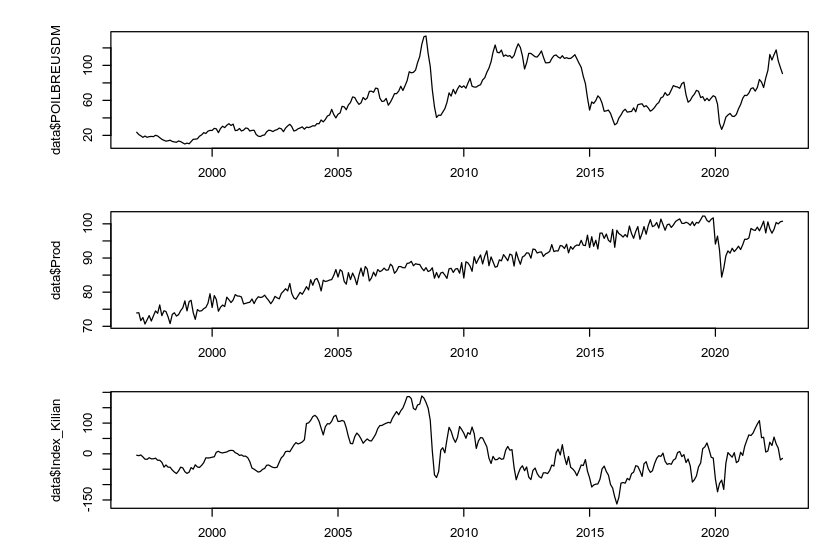

In [69]:
par(mfrow=c(3,1),  mar=c(1, 6, 1, 1)+1)
plot(data$Date,data$POILBREUSDM, type='l')
plot(data$Date,data$Prod, type='l')
plot(data$Date,data$Index_Kilian, type='l')

### Stationarization of time series and tests for stationarity

In our study, we worked on databases presenting the prices of Brent crude oil, the quantities of crude oil produced, and global economic activity. The first step is to make the series stationary because the stationarity of a time series is an important property in making predictions. On the one hand, if the variables are not stationary, the observed correlations may be the result of trends or seasonality rather than a true causality. On the other hand, a stationary time series is better suited for the VAR model because it allows for more precise modeling of the temporal properties of the series, facilitates the estimation of model parameters, and allows for more accurate interpretation of the results.

In [70]:
dlog.Prod=diff(log(Prod),lag=12)
dlog.POILBREUSDM=diff(log(POILBREUSDM),lag = 12)
d12.Index_Kilian=diff(Index_Kilian,lag = 12)

The most common method to achieve stationarity is differentiation, as it removes any trend associated with the series. Since our observations are monthly, it was decided to perform a difference over a year (here, 12 months with our dataset) to eliminate the seasonality effect. To refine the transformation, a log-differentiation was performed, which highlights the relative variations of the time series on a smaller scale. However, it was not possible to apply logarithm to the global economic activity as it was an index and would result in aberrant values.

We plot the differentiated time series.

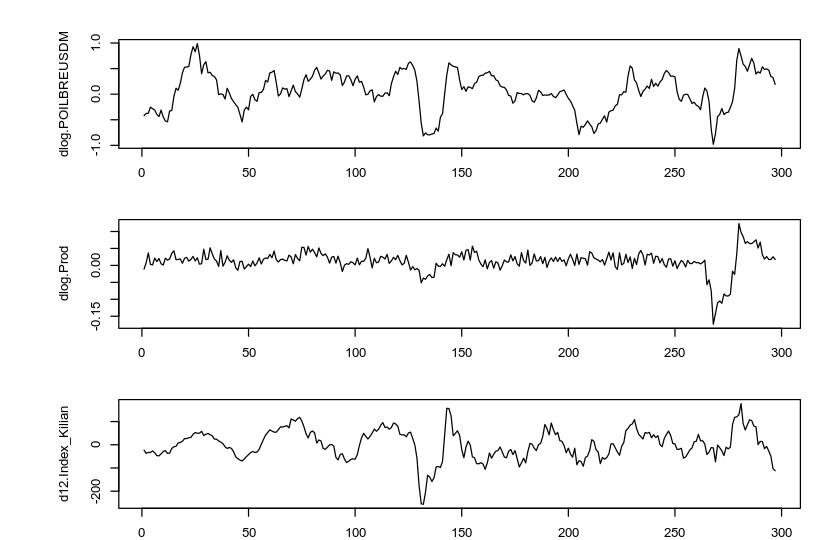

In [100]:
par(mfrow=c(3,1),  mar=c(0.5, 6, 1, 1)+1.5)
plot(dlog.POILBREUSDM,type='l')
plot(dlog.Prod,type='l')
plot(d12.Index_Kilian,type='l')

Finally, to ensure the consistency of the transformations and verify that the stationarity property is respected, we performed a Dickey-Fuller test. The hypotheses associated with this test are as follows :

- H0 : The time series is not stationary (it has a unit root or non-stationary behavior).

- H1 : The time series is stationary (it does not have a unit root or has stationary behavior).

In [72]:
suppressWarnings({
    table=rbind(adf.test(dlog.Prod,k=0),adf.test(dlog.POILBREUSDM,k=0),adf.test(d12.Index_Kilian,k=0))
})

In [73]:
table <- table[, -5]
table <- as.data.frame(table)
table

statistic,parameter,alternative,p.value,data.name
<list>,<list>,<list>,<list>,<list>
-6.163814,0,stationary,0.01,dlog.Prod
-3.257983,0,stationary,0.07853789,dlog.POILBREUSDM
-3.560056,0,stationary,0.03731768,d12.Index_Kilian


- Regarding Brent crude oil prices, the Dickey-Fuller test gives us a p-value of 7%, which means we reject the null hypothesis H0 at the 10% significance level.

- At the production level, the Dickey-Fuller test gives us a p-value significantly lower than 1%, thus we reject the null hypothesis at all usual significance levels.

- In terms of the global economic activity, the Dickey-Fuller test gives us a p-value of 3%, which means we reject the null hypothesis H0 at the 5% significance level.

We create a dataframe with the 3 stationary time series.

In [74]:
dataStatio = cbind(dlog.Prod,d12.Index_Kilian,dlog.POILBREUSDM)

### Implementation of the VectorAutoRegression model to retrieve the different structural shocks

We determine the best lag order using evaluation criteria such as AIC, HQ, SC, and FPE. These criteria help us assess the model's fit with various lag orders. By selecting the lag order with the lowest value among these criteria, we obtain the optimal VAR model.

In [75]:
var_model = VARselect(dataStatio, lag.max = 20, type = "const")
var_model$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
    14     14      2     14

Creating the VAR model using Choleski decomposition :

In [76]:
v1 <- vars::VAR(dataStatio, lag.max = 14, ic = "AIC" )
x1 <- id.chol(v1, order_k = c("dlog.Prod", "d12.Index_Kilian", "dlog.POILBREUSDM")) ## order_k = c(2,1,3)
summary(x1)


Identification Results
---------------------- 

Method: Cholesky
Sample size: 283

Estimated B Matrix (unique decomposition of the covariance matrix): 
                       [,1]        [,2]      [,3]
dlog.Prod        0.01642024  0.00000000 0.0000000
d12.Index_Kilian 3.79315126 20.37678524 0.0000000
dlog.POILBREUSDM 0.01910986  0.01932711 0.1059655


The Cholesky decomposition is a method for decomposing a symmetric and positive definite matrix into a product of two triangular matrices, one upper and one lower. In the case of estimating the VAR model, the Cholesky decomposition is used to determine the order in which the variables are affected by structural shocks.

We can examine the impulse response analysis for our variable.

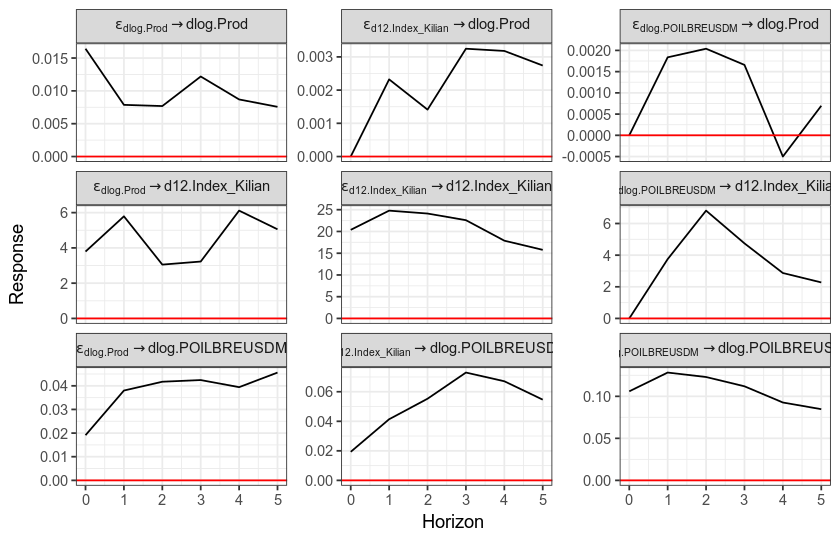

In [77]:
i1 = irf(x1, n.ahead = 6)
plot(i1, scales = 'free_y')

#### Alternative approach to implement a VAR model

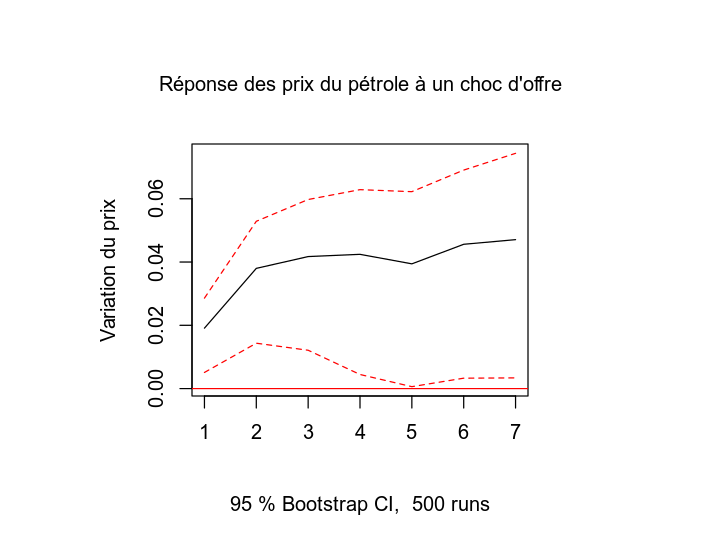

In [78]:
model = VAR(dataStatio, p = 14, type = "const")
irf_prod1 = irf(model, impulse = "dlog.Prod", response = "dlog.POILBREUSDM", n.ahead = 6, runs = 500)
options(repr.plot.width = 6, repr.plot.height = 4.5)
plot(irf_prod1, main = "Réponse des prix du pétrole à un choc d'offre", xlab = "mois", ylab = "Variation du prix")

We retrieve the residuals from the reduced-form equation of the model (see theoretical framework in the Git).

In [79]:
residus = resid(model)

Then, we retrieve the structural shocks from a matrix product.

After estimating the VAR model using the Cholesky decomposition, we can retrieve the structural shocks by multiplying the lower triangular matrix of the Cholesky decomposition with the residuals of the reduced-form VAR model. This gives us a series of structural shocks that we can analyze further.

In [80]:
B = x1[["B"]]
Binv = solve(B)
residustranspo = t(residus)
matrice_residustranspo = as.matrix(residustranspo)
chocs_struct = Binv%*%matrice_residustranspo
chocs_structProd = chocs_struct[1, ]

We then create a dataframe containing the oil production structural shocks over time as it is considered the most exogenous variable.

In [81]:
data_chocProd = data.frame(chocs_structProd)
Date = seq.Date(from = as.Date("1999-03-01"), to = as.Date("2022-09-01"), by = "month")
data_chocProd = cbind(Date = Date, data_chocProd)

To observe the year-over-year effect, we employ the rollapply function to calculate the mean of each group of 12 data points, and then store these means in a dataframe.

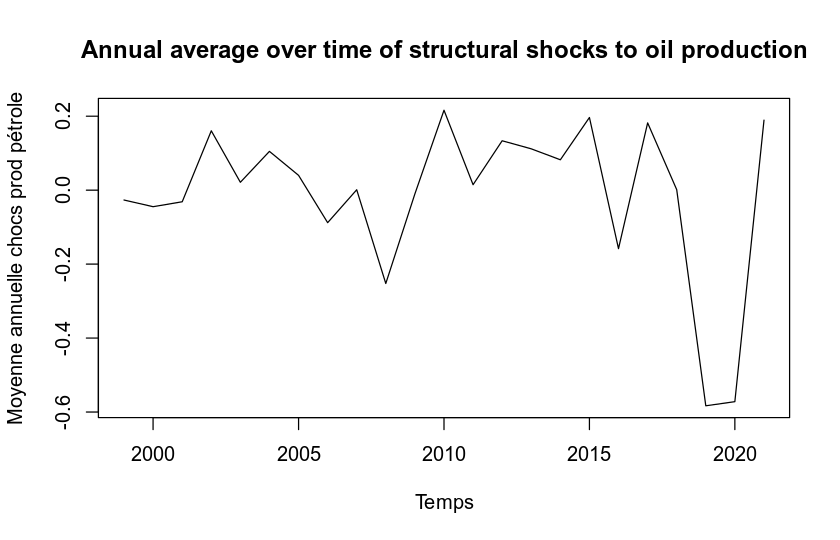

In [90]:
data_moy = data.frame(rollapply(data_chocProd$chocs_structProd, width = 12, FUN = mean, align = "right", by = 12))
Date = seq.Date(from = as.Date("1999-01-01"), to = as.Date("2021-01-01"), by = "years")
data_moy = cbind(Date = Date,data_moy)
names(data_moy)[2] <- "moyenne annuelle chocs prod"
options(repr.plot.width = 7, repr.plot.height = 4.5)
plot(data_moy, type = "l", main='Annual average over time of structural shocks to oil production',xlab = "Temps", ylab = "Moyenne annuelle chocs prod pétrole")

### Analysis of the impact of structural oil production shocks on different sectors of the economy

Local projection of structural shocks can be done on the French dataset to study the impact of oil production structural shocks on different sectors of the economy. This involves using local regression to analyze how the impact of the shock varies over time and space based on local characteristics. The dataset can be preprocessed to include relevant variables, such as inflation, GDP, and sector-specific indicators, and then a local regression can be performed to estimate the effects of the shock on each sector. The results of the analysis can provide insights into the distributional effects of structural shocks on the economy and can be used to inform policy decisions.

Here is the implemented function to retrieve the coefficients of the regression by iterating over each of the lags :

In [83]:
calculate_regression_coefficients <- function(data, lags,x,y) {
  # Store the estimated coefficients
  coefficients <- NULL
  upper <- NULL
  lower <- NULL
  
  for (lag in lags) {
    # Shift the Y series by a certain number of periods
    data_lagged <- mutate(data, Y_forward = lag(x, lag))
    
    # Adjust the regression model
    model <- lm(y ~ Y_forward, data = data_lagged)
    
    # Store the estimated coefficients in a dataframe
    coefficients <- rbind(coefficients, data.frame(Lag = lag, Coefficient = coef(model)["Y_forward"]))
    
    #Store upper and lower border
    upper <- rbind(upper, data.frame(Lag = lag, Upper = confint(model, level = 0.95)[2,2]))
    lower <- rbind(lower, data.frame(Lag = lag, Lower = confint(model, level = 0.95)[2,1]))
  }
  coefficients <- merge(coefficients, upper, by = "Lag")
  coefficients <- merge(coefficients, lower, by = "Lag")
  return(coefficients)
}

#### Importing data for France’s sectorial analysis

In [84]:
data_KEI_GDP_France = read_excel("data_statapp/data_KEI_GDP_France.xlsx")

data_KEI_INFLATION_France = read_excel("data_statapp/data_KEI_INFLATION_France.xlsx")

data_KEI_Prod_Industrielle_France = read_excel("data_statapp/data_KEI_Prod_Industrielle_France.xlsx")

data_KEI_Secteur_Manufacturier_France = read_excel("data_statapp/data_KEI_Secteur_Manufacturier_France.xlsx")

data_KEI_Commerce_Détail_France = read_excel("data_statapp/data_KEI_Commerce_Détail_France.xlsx")

data_KEI_Secteur_logement_France = read_excel("data_statapp/data_KEI_Secteur_logement_France.xlsx")

Setting up the dataframe for France

In [85]:
data_france <- data_KEI_GDP_France %>%
  inner_join(data_KEI_INFLATION_France, by = "Date") %>%
  inner_join(data_KEI_Commerce_Détail_France, by = "Date") %>%
  inner_join(data_KEI_Prod_Industrielle_France, by = "Date") %>%
  inner_join(data_KEI_Secteur_Manufacturier_France, by = "Date") %>%
  inner_join(data_KEI_Secteur_logement_France, by = "Date")

On the one hand, we convert the data so that it can be interpreted during regressions, and on the other hand, we match the time scales of each of the involved data frames.

In [86]:
data_france$GDP=as.numeric(data_france$GDP)
data_france$Inflation=as.numeric(data_france$Inflation)
data_france$`Commerce de détail`=as.numeric(data_france$`Commerce de détail`)
data_france$`Production Industrielle`=as.numeric(data_france$`Production Industrielle`)
data_france$`Secteur Manufacturier`=as.numeric(data_france$`Secteur Manufacturier`)
data_france$`Secteur logement`=as.numeric(data_france$`Secteur logement`)

data_france$Date = NULL
Date = seq.Date(from = as.Date("1980-01-01"), to = as.Date("2022-05-01"), by = "month")
data_france = cbind(Date = Date, data_france)

In [87]:
dataFRA = merge(data_france, data_chocProd, by = "Date")
dataFRA = na.omit(dataFRA)
head(dataFRA)

,Date,GDP,Inflation,Commerce de détail,Production Industrielle,Secteur Manufacturier,Secteur logement,chocs_structProd
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1999-03-01,99.89168,78.47,65.19457,102.08,103.45,81.19554,1.68282002
2,1999-04-01,99.87429,78.69,64.99458,102.90,104.54,85.85700,-1.50044193
3,1999-05-01,99.87847,78.70,65.39455,103.34,105.18,85.78204,-0.97698397
4,1999-06-01,99.92276,78.69,65.49454,104.75,106.35,80.76657,-0.03226950
5,1999-07-01,100.01190,78.48,65.99450,104.98,106.56,75.31637,0.04102183
6,1999-08-01,100.14257,78.61,64.19465,103.04,104.25,89.39433,0.28611752


Next, we use a for loop to iterate through each column in dataFRA, except for the first and last columns. For each column, we calculate the regression coefficients using the lagged values of chocs_structProd as the explaining variable. Then, we plot these 12 coefficients to visually represent how the impact of oil production structural shock varies over time for each variable in the data frame. The title of each plot is the corresponding column name in the data frame. This analysis provides a visual representation of the relationship between the impact of the structural shock in oil production and the other variables considered in the data frame over time.

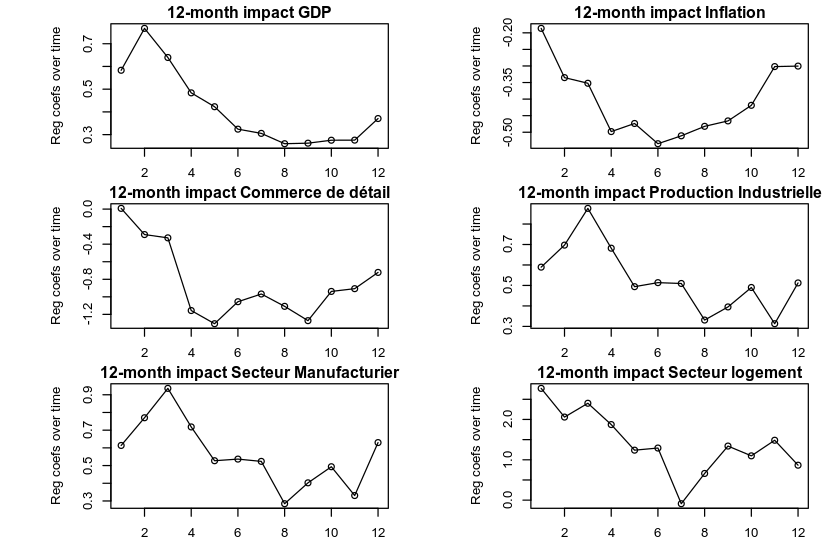

In [88]:
par(mfrow=c(3,2),mar=c(1, 6, 0.5, 1) + 1)
lags <- 1:12
for (col in colnames(dataFRA)[-c(1, length(colnames(dataFRA)))]) {
  coefficients = calculate_regression_coefficients(data = dataFRA, lags = lags,dataFRA$chocs_structProd,dataFRA[[col]])

  suppressWarnings({plot(c(1:12),coefficients$Coefficient, main = paste("12-month impact" ,col), xlab = "Forward (en mois)", ylab = "Reg coefs over time",'o-')
})
                  }

These results can then be used to provide analyses, reform options, and impact studies in the field of public finance, public expenditure, as well as fiscal policy, social policies, employment, sectoral policies, and more. In our context, this study project was conducted as an experimental initiative with the support of the French Treasury.